# Nonlinear Resistors: Analysis and Visualization

author: Reza Mohammadi

email: mohamadi.reza@mail.um.ac.ir

## Introduction
Nonlinear resistors are components whose resistance changes with the voltage across them or the current passing through them. Unlike linear resistors, their voltage-current (V-I) relationship is not a straight line, making their behavior more complex and requiring advanced analysis techniques.

This notebook provides an overview of nonlinear resistors, including their characteristics, mathematical modeling, applications, and circuit analysis. We'll use Python libraries such as `schemdraw` for visualizing circuits and `PySpice` for simulating and analyzing their behavior.


## Characteristics of Nonlinear Resistors


### Examples of Nonlinear Resistors
- **Diodes**: Exhibit exponential V-I characteristics.
- **Zener Diodes**: Show breakdown behavior at a specific reverse voltage.
- **Varistors**: Used for voltage clamping with a highly nonlinear resistance.
- **Thermistors**: Resistances vary with temperature (NTC/PTC types).

### Mathematical Modeling
Nonlinear resistors are often characterized by their voltage-current relationship, which can be described using equations:

#### Example: Diode
The Shockley diode equation is:
\[
$$I = I_S \left( e^{\frac{V}{n V_T}} - 1 \right)$$
\]
Where:
- \( I \): Current through the diode
- \( V \): Voltage across the diode
- \( I_S \): Reverse saturation current
- \( n \): Ideality factor (typically between 1 and 2)
- \( V_T \): Thermal voltage, \( $$V_T = \frac{kT}{q} $$\)


#### Example: Thermistor
For an NTC thermistor, the resistance \( R \) as a function of temperature \( T \) is given by:
\[
$$R(T) = R_0 e^{\beta \left( \frac{1}{T} - \frac{1}{T_0} \right)}$$
\]
Where:
- \( $R_0 $\): Resistance at reference temperature \( $T_0 $\)
- \( $\beta $\): Material constant
- \( T \): Absolute temperature (in Kelvin)


## Visualization with schemdraw
Let's start by visualizing a simple circuit containing a nonlinear resistor (e.g., a diode):

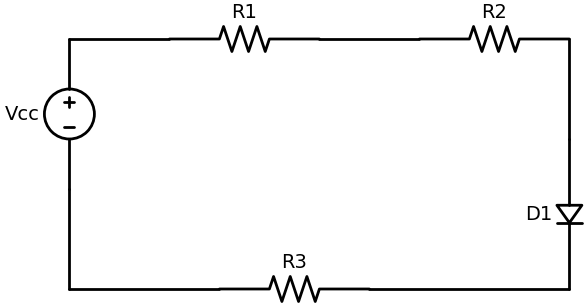

In [4]:
import schemdraw
import schemdraw.elements as elm

# Create a schematic drawing using schemdraw
with schemdraw.Drawing() as d:
    # Add a voltage source (Vcc)
    vcc = d.add(elm.SourceV().label('Vcc'))  

    # Add a wire to the right of the voltage source
    d.add(elm.Line().right().length(2))  

    # Add the first resistor (R1) to the right of the wire
    d.add(elm.Resistor().label('R1'))  

    # Add another wire to the right of R1
    d.add(elm.Line().right().length(2))  

    # Add the second resistor (R2) to the right of the wire
    d.add(elm.Resistor().label('R2'))  

    # Add a wire going down from R2
    d.add(elm.Line().down().length(2))  

    # Add a diode (D1) below the wire
    d.add(elm.Diode().label('D1'))  

    # Add a wire going left from D1
    d.add(elm.Line().left().length(4))  

    # Add the third resistor (R3) to the left of the wire
    d.add(elm.Resistor().label('R3'))  

    # Add another wire going left from R3
    d.add(elm.Line().left().length(3))  

    # Add a wire connecting back to the starting point of Vcc
    d.add(elm.Line().to(vcc.start))  

    # Render the drawing
    d.draw()



**Explanation**: The above code uses the `schemdraw` library to draw a closed circuit diagram with a voltage source, a resistor, and a diode connected in series. The `label` method annotates each element for clarity.

![Simple Circuit with Diode](https://tse2.mm.bing.net/th?id=OIP.3RmNFAIw74yVp7xPPZuspwHaEF&pid=Api)


![Diode V-I Characteristics](https://tse2.mm.bing.net/th?id=OIP.6aZ-X_SyqsMgci43eX3SYAHaEz&pid=Api)


## Simulation with PySpice


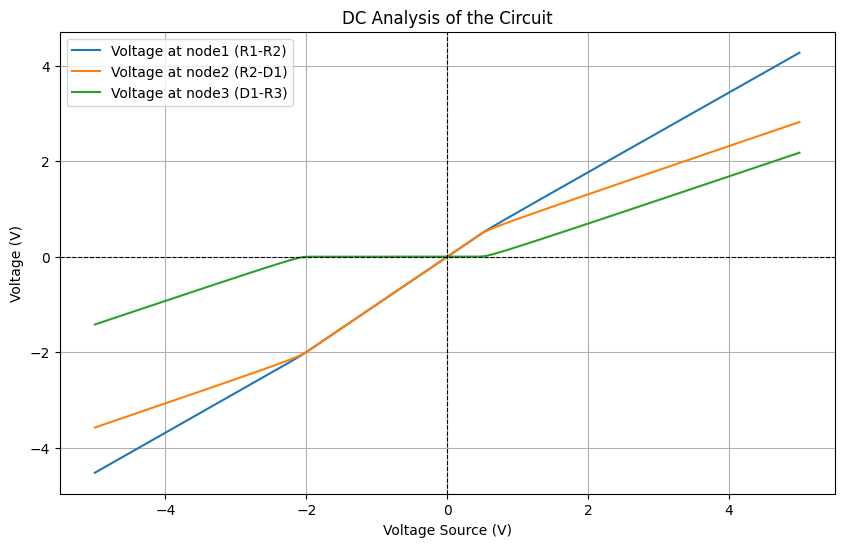

In [1]:
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import matplotlib.pyplot as plt

# Create a new circuit with the name 'Simple Circuit'
circuit = Circuit('Simple Circuit')

# Add a DC voltage source (V1) with 12V connected between 'Vcc' and ground
circuit.V(1, 'Vcc', circuit.gnd, 12@u_V)

# Add a resistor (R1) of 1 kOhm between 'Vcc' and 'node1'
circuit.R(1, 'Vcc', 'node1', 1@u_kOhm)

# Add another resistor (R2) of 2 kOhm between 'node1' and 'node2'
circuit.R(2, 'node1', 'node2', 2@u_kOhm)

# Add a diode (D1) between 'node2' and 'node3'
circuit.D(1, 'node2', 'node3', model='D')

# Add a resistor (R3) of 3 kOhm between 'node3' and ground
circuit.R(3, 'node3', circuit.gnd, 3@u_kOhm)

# Specify the path to the SPICE model library
spice_library = SpiceLibrary('/usr/share/ngspice/models')

# Define a diode model 'D' with its characteristics
circuit.model('D', 'D', IS=1e-14, N=1, BV=2, IBV=1e-6)

# Create a simulator object for the circuit and set the simulation temperature
simulator = circuit.simulator(temperature=25, nominal_temperature=25)

# Perform a DC sweep analysis for the voltage source V1 from -5V to 5V with a step of 0.01V
dc_analysis = simulator.dc(V1=slice(-5, 5, 0.01))

# Extract voltages at different nodes during the DC sweep
node1_voltages = [float(dc_analysis['node1'][step]) for step in range(len(dc_analysis.sweep))]
node2_voltages = [float(dc_analysis['node2'][step]) for step in range(len(dc_analysis.sweep))]
node3_voltages = [float(dc_analysis['node3'][step]) for step in range(len(dc_analysis.sweep))]
source_voltages = [float(dc_analysis.sweep[step]) for step in range(len(dc_analysis.sweep))]

# Plot the voltage at each node as a function of the source voltage
plt.figure(figsize=(10, 6))
plt.plot(source_voltages, node1_voltages, label='Voltage at node1 (R1-R2)')
plt.plot(source_voltages, node2_voltages, label='Voltage at node2 (R2-D1)')
plt.plot(source_voltages, node3_voltages, label='Voltage at node3 (D1-R3)')
plt.title('DC Analysis of the Circuit')
plt.xlabel('Voltage Source (V)')
plt.ylabel('Voltage (V)')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a horizontal line at y=0
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')  # Add a vertical line at x=0
plt.legend()
plt.grid()
plt.show()


### Example Using Thermistor Equation
We can also model the behavior of a thermistor:

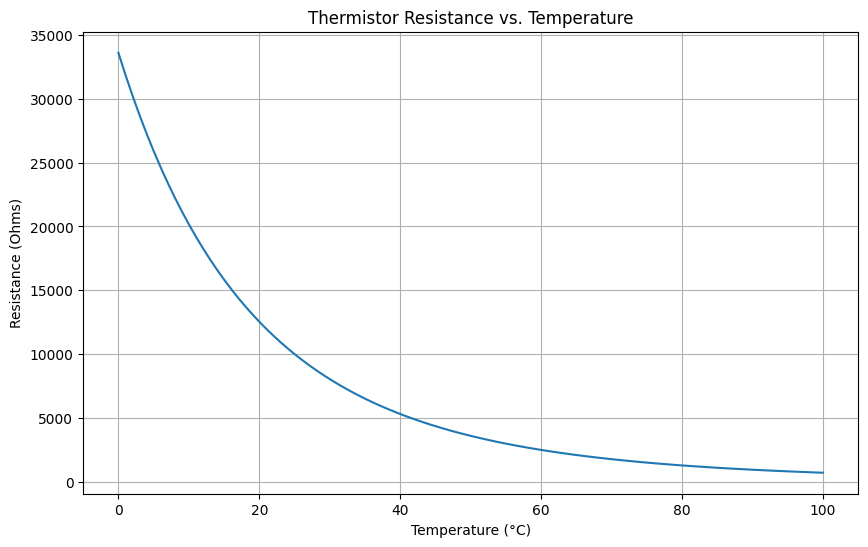

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants for the thermistor
R0 = 10e3  # Resistance at reference temperature (10 kOhms)
T0 = 298.15  # Reference temperature in Kelvin (25°C)
beta = 3950  # Beta constant of the thermistor

# Generate temperature values from 0°C to 100°C (in Kelvin)
T = np.linspace(273.15, 373.15, 100)

# Calculate resistance using the thermistor equation
R = R0 * np.exp(beta * (1/T - 1/T0))

# Plot the resistance as a function of temperature
plt.figure(figsize=(10, 6))
plt.plot(T - 273.15, R)  # Convert temperature to Celsius for the x-axis
plt.title('Thermistor Resistance vs. Temperature')
plt.xlabel('Temperature (°C)')  # Label for temperature in Celsius
plt.ylabel('Resistance (Ohms)')  # Label for resistance in Ohms
plt.grid()
plt.show()


**Explanation**: This code models the resistance-temperature relationship of an NTC thermistor using its characteristic equation. It calculates resistance values over a temperature range and visualizes the results in a plot.


![Thermistor Resistance vs. Temperature](https://tse3.mm.bing.net/th?id=OIP.1egyb447YjCx89cpAghuVgHaEo&pid=Api)


## Applications of Nonlinear Resistors
- **Voltage Regulation**: Zener diodes in power supplies.
- **Surge Protection**: Varistors in electrical systems.
- **Temperature Sensing**: Thermistors in HVAC systems.
- **Clamping Circuits**: Protecting sensitive electronics from overvoltage.
- **Power Control**: SCRs in AC and DC systems.
- **Lighting**: Gas discharge and neon lamps in displays and indicators.

## Conclusion
Nonlinear resistors play a critical role in modern electronics. Their ability to respond dynamically to changing voltage and current conditions enables their use in various applications, from power regulation to sensing and protection. Understanding their behavior through mathematical modeling and simulation is crucial for designing effective and efficient circuits.

## References
1. Sedra, A. S., & Smith, K. C. (2020). *Microelectronic Circuits*.
2. Paul W. Tuinenga. (2019). *SPICE: A Guide to Circuit Simulation and Analysis.*
3. [PySpice Documentation](https://pyspice.fabrice-salvaire.fr/)
4. [Schemdraw Documentation](https://schemdraw.readthedocs.io/)
5. [Image: Diode Circuit](https://tse3.mm.bing.net/th?id=OIP.smtNNsx69Cb50yXfkHASTgHaEK&pid=Api)
6. [Image: Diode V-I Characteristics](https://tse2.mm.bing.net/th?id=OIP.6aZ-X_SyqsMgci43eX3SYAHaEz&pid=Api)
7. [Image: Thermistor Resistance vs. Temperature](https://tse3.mm.bing.net/th?id=OIP.1egyb447YjCx89cpAghuVgHaEo&pid=Api)